<a href="https://www.kaggle.com/toygarr/sentiment-aware-model-to-classify-tweets-real-time?scriptVersionId=86131423" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment-aware Contextual Model for Tweets

Sentiment Analysis has an important role in today’s world especially for private companies
which hold lots of data. The massive amount of data generated by Twitter present a unique
opportunity for sentiment analysis. However, it is challenging to build an accurate predictive
model to identify sentiments, which may lack sufficient context due to the length limit. In
addition, sentimental and regular ones can be hard to separate because of word ambiguity. In
this notebook, I will be proposing the phases of text pre-processing, visual analysis and modeling.

***I tried to keep code as simple as possible to remain understandable.***

Proposed **BERT-CNN-BiLSTM** learning pipeline, which consists of **three sequential modules**.<br />
BERT produces competitive results, and can be considered as one of the new electricity of natural
language processing tasks such as sentiment analysis, named entity recognition (NER), and topic
modeling. The combination of CNN and BiLSTM models requires a particular design, since each
model has a specific architecture and its own strengths:<br />
• BERT is utilized to transform word tokens from the raw Tweet messages to contextual word
embeddings.<br />
• CNN is known for its ability to extract as many features as possible from the text.<br />
• BiLSTM keeps the chronological order between words in a document, thus it has the ability
to ignore unnecessary words using the delete gate.<br />

#### _In last update, Error Analysis is added based on test set._

**References:**<br />
1) [A Sentiment-Aware Contextual Model for Real-Time Disaster Prediction Using Twitter Data](https://www.mdpi.com/1999-5903/13/7/163/htm) -> The idea comes from and really worth to check on, however, i am not using the same model.<br />
2) [Automatic identification of eyewitness messages on twitter during disasters](https://reader.elsevier.com/reader/sd/pii/S0306457319303590?token=985D740724AEDB812611486EBAD3B68FA4393520D4DCD96FDADE4A642A9805D728945987C1BBBE0FDAA8EC3684E372C7&originRegion=eu-west-1&originCreation=20210920022341)<br />
3) [Convolutional Neural Networks for Sentence Classification](http://arxiv.org/abs/1408.5882)<br />
4) [BERT: Pre-training of Deep Bidirectional Transformers for Language
               Understanding](http://arxiv.org/abs/1810.04805)<br />
5) [LMAES' Notebook](https://www.kaggle.com/lmasca/disaster-tweets-using-bert-embeddings-and-lstm)<br />
6) [PAOLO RIPAMONTI's Notebook](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

## > If you find my work useful please don't forget to **Upvote!**  so it can reach more people.

In [40]:
# few of the imports are just for checking while coding not included in the rest of notebook.

# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords


# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # not actively using
from sklearn.decomposition import LatentDirichletAllocation, NMF # not actively using
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Utility
import logging
import itertools


# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# for build our model
import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

# Setting some options for general use.
import os
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"

# Read Dataset

### Dataset details:
http://help.sentiment140.com the site is pretty old and most of the links are broken, however, check out for more detail.

Latest availability of dataset: https://www.kaggle.com/kazanova/sentiment140

@ONLINE {Sentiment140, <br />
    author = "Go, Alec and Bhayani, Richa and Huang, Lei", <br />
    title  = "Twitter Sentiment Classification using Distant Supervision", <br />
    year   = "2009", <br />
    url    = "http://help.sentiment140.com/home"
}

*According to the creators of the dataset:* \
"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search".


The data is a CSV with emoticons removed. Data file format has 6 fields:
* target: the polarity of the tweet (0 = negative, 4 = positive)<br/> -> We will insert (2 = neutral) manually using threshold.
* ids: The id of the tweet
* date: the date of the tweet
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted
* text: the text of the tweet

In [3]:
# Read the data
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', 
                 encoding = DATASET_ENCODING, names=DATASET_COLUMNS)

In [4]:
# Raw data
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Map target label to String
* 0 -> NEGATIVE
* 2 -> NEUTRAL
* 4 -> POSITIVE

We prepare "2" for "neutral" label beforehand.

In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 716 ms, sys: 21.4 ms, total: 737 ms
Wall time: 741 ms


# Cleaning Text

So basically what we will do here:

* Remove urls, html tags and punctuations <br/>

Based on this [paper](https://aclanthology.org/2020.pam-1.15.pdf), removing punctuations is important for BERT both in statistical and sentimental way. It significantly affects counting.

On the other hand, twitter data is a real mess so generally may not has obvious positive impact on the results. In our case we ignored the punctuations, but keep that paper in mind.

In [7]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)



def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
df['text_clean'] = df['text'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))

In [8]:
df.head()

,target,ids,date,flag,user,text,text_clean
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot Awww thats a bummer You shoulda ...
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...


# Visualizing the Data

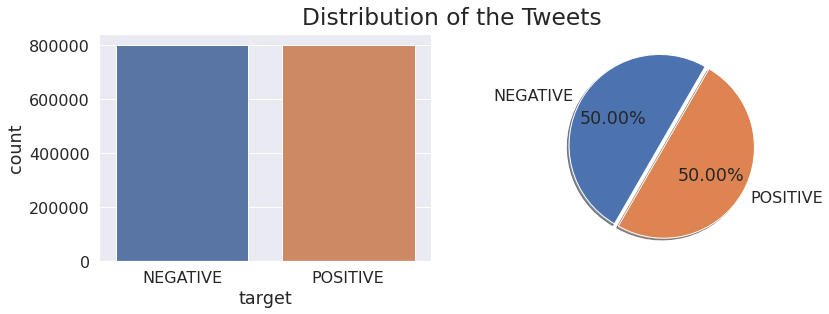

In [9]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), dpi=70)
sns.countplot(df['target'], ax=axes[0])
axes[1].pie(df['target'].value_counts(),
            labels=[NEGATIVE, POSITIVE],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

________________

As a quick and easy observation, we can say that dataset has no imbalanced label problem. Negative and Positive labels are equal. The situation of equilibrium will let model to learn more accurate. However, should not be forgotten, dataset might has lots of mislabelled text due to way of collection which has only parameter as **":)" : positive** or **":(" : negative**. The problem is that lots of user may send ":)" or ":(" ironically.  

> An example: "u look like a sh\*t today :)"

This problem may decrease the accuracy, however, end of the day we're creating a sentiment-aware model depending on the words.

_____

In [10]:
# Creating a new feature for the visualization.

df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df_x, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df_x.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

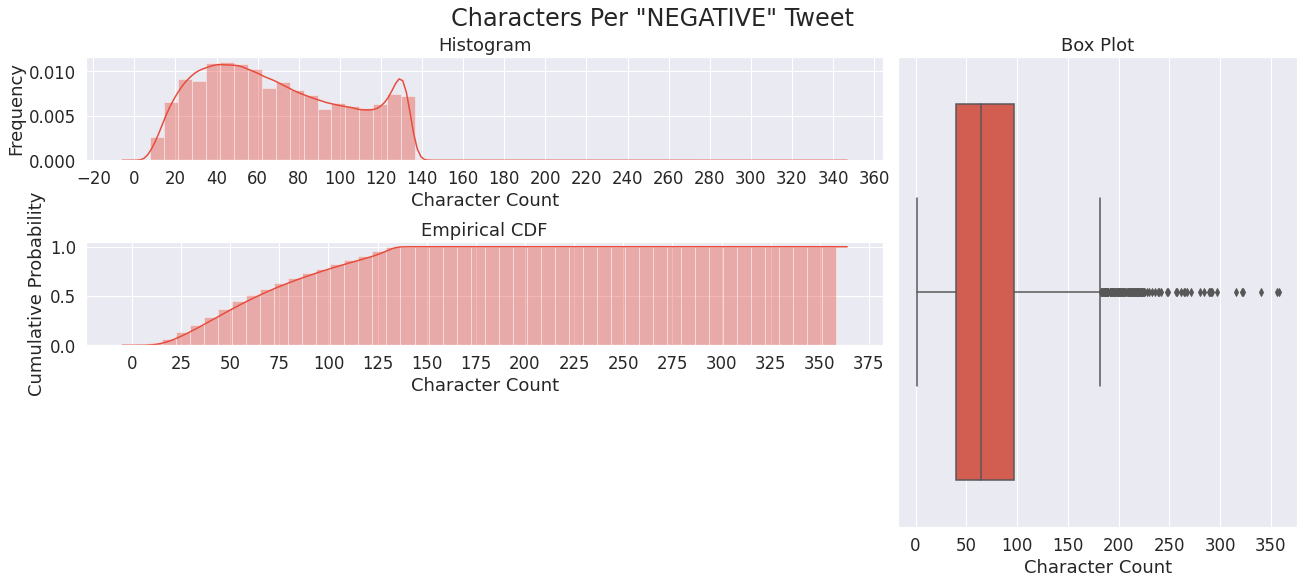

In [11]:
plot_dist3(df[df['target'] == 'NEGATIVE'], 'Character Count',
           'Characters Per "NEGATIVE" Tweet')

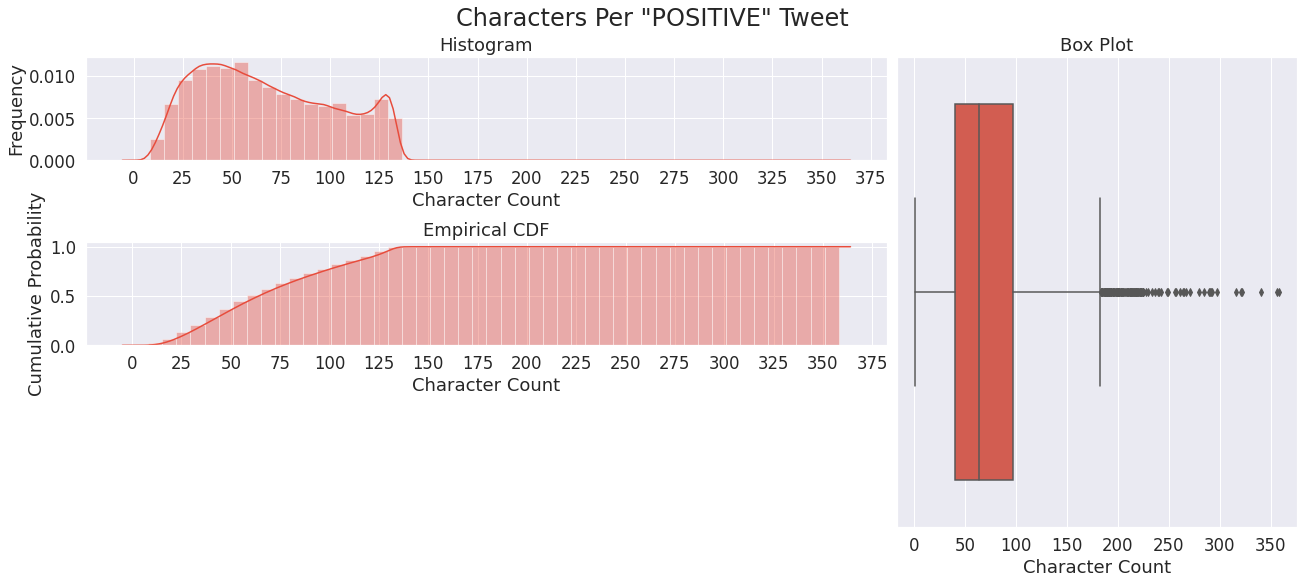

In [12]:
plot_dist3(df[df['target'] == "POSITIVE"], 'Character Count',
           'Characters Per "POSITIVE" Tweet')

# Setup environment to build model

In [13]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [14]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2022-01-25 13:10:57.090137: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-25 13:10:57.093540: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-25 13:10:57.093571: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-25 13:10:57.093599: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (58c15260f7a9): /proc/driver/nvidia/version does not exist
2022-01-25 13:10:57.096552: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [15]:
# hyperparameters
max_length = 140 # max length of tweets in the dataset collection time
batch_size = 512 # huge batch_size is used because it affects training time significantly. /we have really big dataset/

____
Again we will use bert-base-uncased because we don't have proper written texts, mostly chaos. <br/>
Do not need to consider cased characters.
____

In [16]:
# Bert Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Splitting the data
We have huge dataset which allows us taking only 1% of whole set for splitting to the development and the test set.

To be more clear, in the code below, first we take 1% of whole set as the test set. Afterwards, we take 1% of the rest of data which can be defined as 99% to create development set.

In [17]:
train_df, test = train_test_split(df, test_size=0.01, random_state=42)
x_train, dev = train_test_split(train_df, test_size=0.01, random_state=42)

In [21]:
print(x_train.shape)
print(test.shape)
print(dev.shape)

(1568160, 8)
(16000, 8)
(15840, 8)


___

### Data Decrease
I will be taking 500k of the training data because it takes too much time to train with whole 1.5m different texts. However, you can try that to see how datasize affects the results.
___

In [22]:
train = x_train[:500000]

# Label Encoder

In [23]:
labels = train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(train.target.tolist())

y_train = encoder.transform(train.target.tolist())
y_test = encoder.transform(test.target.tolist())
y_dev = encoder.transform(dev.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (500000, 1)
y_test (16000, 1)


In [25]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [26]:
train_encoded = bert_encode(train.text_clean)
dev_encoded = bert_encode(dev.text_clean)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

# Proposed Model

In [27]:
def bert_model():

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
    x = tf.keras.layers.Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(input_word_ids, outputs)
    
    return model

In [35]:
with strategy.scope():
    model = bert_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 140)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 140, 768)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 138, 32)           73760     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 138, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201 

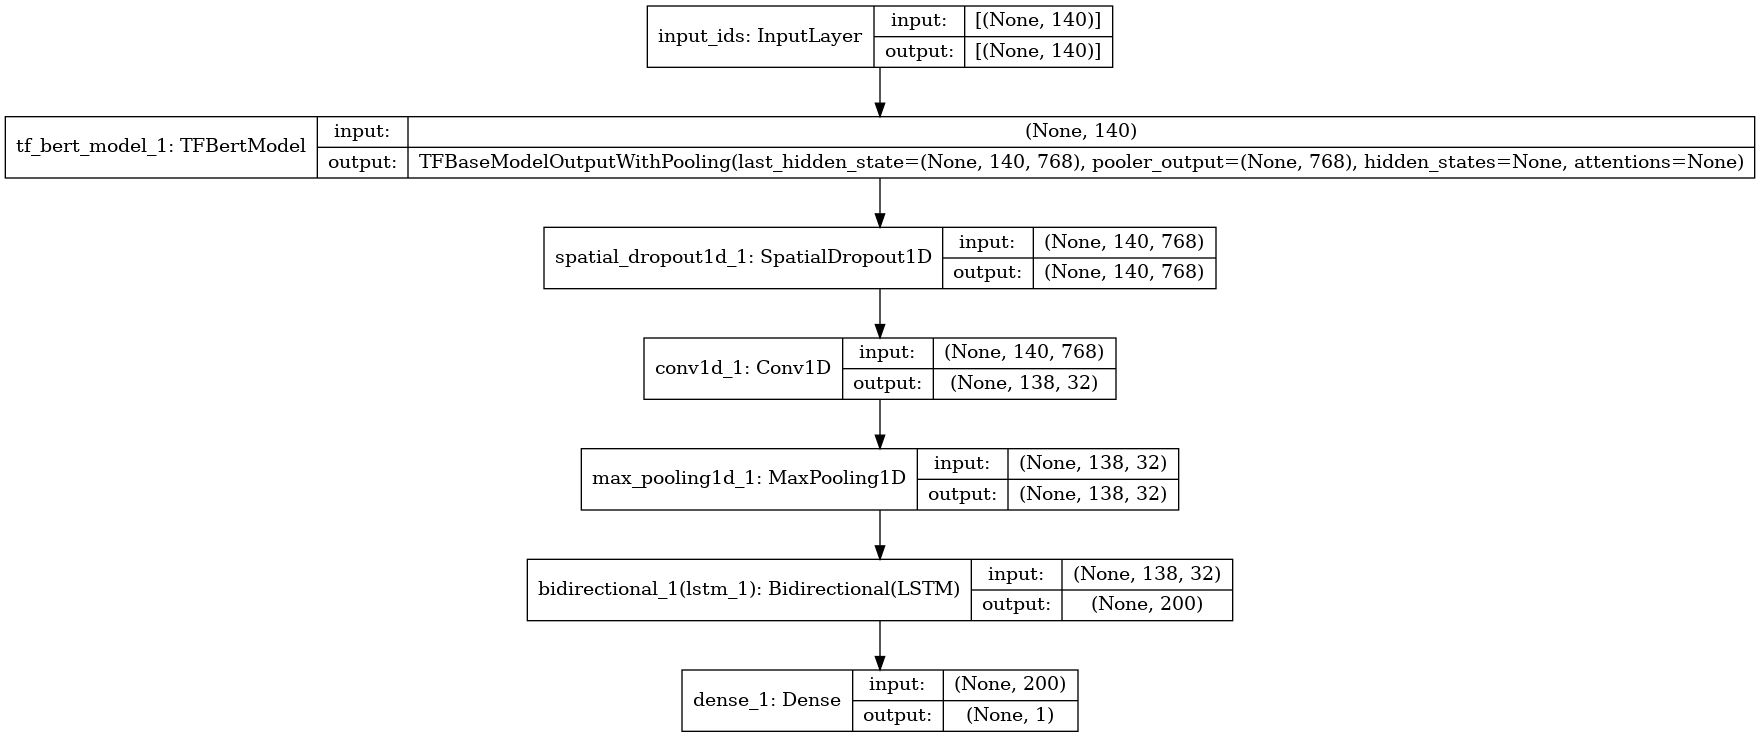

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5)]

In [38]:
# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=dev_dataset,
    verbose=1,
    callbacks = callbacks)

Epoch 1/3
977/977 [==============================] - 456s 384ms/step - loss: 0.4223 - accuracy: 0.8002 - val_loss: 0.3492 - val_accuracy: 0.8516
Epoch 2/3
977/977 [==============================] - 311s 318ms/step - loss: 0.3118 - accuracy: 0.8658 - val_loss: 0.3616 - val_accuracy: 0.8495
Epoch 3/3
977/977 [==============================] - 311s 319ms/step - loss: 0.2479 - accuracy: 0.8976 - val_loss: 0.4217 - val_accuracy: 0.8449


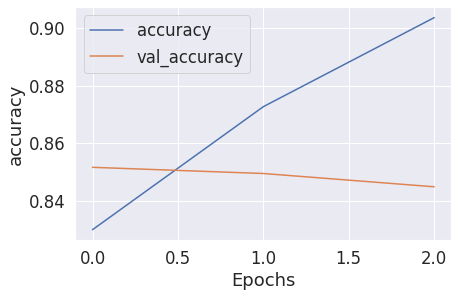

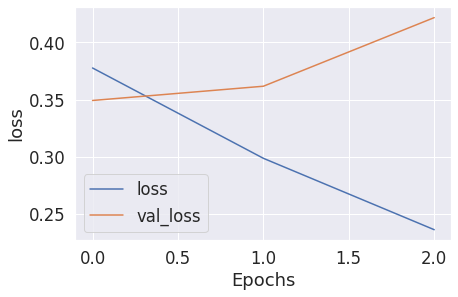

In [41]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Predict Manually Before Using Test Data

Decoder to be able to see results as labelled negative, positive or neutral <br/>
**Recap:** The threshold was determined as (0.4, 0.7). <br/>
<br/>
If you want to add neutral label, send include_neutral = **True** parameter after the given text.

In [42]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [43]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [44]:
predict("I hate the economy")

{'label': 'NEGATIVE',
 'score': 0.0017701685428619385,
 'elapsed_time': 9.163167238235474}

In [45]:
predict("I would prefer writing a crawler to create this dataset but i couldn't", True)

{'label': 'NEGATIVE',
 'score': 0.0026315152645111084,
 'elapsed_time': 0.3620774745941162}

In [46]:
predict("I LOVE NLP")

{'label': 'POSITIVE',
 'score': 0.9966869354248047,
 'elapsed_time': 0.36257004737854004}

In [51]:
predict("life is really strange isn't it? just the combination of laugh and cry", True)

{'label': 'NEUTRAL',
 'score': 0.5873827338218689,
 'elapsed_time': 0.37584924697875977}

In [52]:
predict("ESL is the world's largest esports company, leading the industry across the most popular video games.\
        We're proud they've chosen us to help them deliver their launchers to gamers all over the world. Read the full review")

{'label': 'POSITIVE',
 'score': 0.9986441135406494,
 'elapsed_time': 0.38617372512817383}

In [53]:
predict("Excited to present a tutorial on 'Modular and Parameter-Efficient Fine-Tuning for NLP Models' \
        at #EMNLP2022 with @PfeiffJo & @licwu.")

{'label': 'POSITIVE',
 'score': 0.9987726807594299,
 'elapsed_time': 0.3658010959625244}

In [54]:
predict("Had a song stuck in my head. Thirty seconds later I'm listening to it, thanks to the internet,\
        and Apple/YouTube Music. In the bad old days I'd browse record stores for hours in the hope that the title might jog my memory.\
        It really is a wonderful time to be alive!")

{'label': 'POSITIVE',
 'score': 0.6625287532806396,
 'elapsed_time': 0.3698892593383789}

In [55]:
predict("i don't say this lightly - hemingway's life ended by suicide. His life was actually a loss")

{'label': 'POSITIVE',
 'score': 0.7471669912338257,
 'elapsed_time': 0.37294840812683105}

In [56]:
predict("these r not ur problems dear!!! these r ur x bf's commitng suicide")

{'label': 'NEGATIVE',
 'score': 0.06072920560836792,
 'elapsed_time': 0.3667576313018799}

In [58]:
predict("i hve no idea about i love the uni or not", True)

{'label': 'NEUTRAL',
 'score': 0.6711433529853821,
 'elapsed_time': 0.3648052215576172}

In [59]:
predict("For the third time in four years, the Warriors are champions once again.\
This time, they wasted no time in the NBA Finals, dispatching LeBron James and the Cavs in four straight games.\
Here’s how they sealed the championship in Game 4. https://twitter.com/i/moments/1005197277663641600")

{'label': 'NEGATIVE',
 'score': 0.008334219455718994,
 'elapsed_time': 0.36905455589294434}

In [60]:
predict("I found some old Reddit post in which one guy from english-speaking country complains that\
the names in The Witcher books are 'too difficult' and non- intuitive for english speaker.\
Man, let me introduce you to 'The books werent written only/for english speakers.'' #witcher")

{'label': 'POSITIVE',
 'score': 0.5326785445213318,
 'elapsed_time': 0.377932071685791}

In [61]:
predict("I forgot how cringy all the Slavic names sound read it English \
YOU'RE PRONOUNCING IT ALL WRONG MY EARS ARE HURTING AND I DON'T EVEN HAVE HEARING AIDS IN")

{'label': 'NEGATIVE',
 'score': 0.005570083856582642,
 'elapsed_time': 0.36989665031433105}

In [62]:
predict("fun fact: ai cannot predict everything right")

{'label': 'POSITIVE',
 'score': 0.9516025185585022,
 'elapsed_time': 0.3682122230529785}

In [65]:
predict("brain is just machine", True)

{'label': 'NEUTRAL',
 'score': 0.5400834679603577,
 'elapsed_time': 0.388995885848999}

___
# Personal Observations
#### After trying lots of hyperparameters and different models on very different test distribution, adding things like extra dense layers, gives the models an appreciably robustness. Even though current model has no extra dense layer, you can check the previous version.

#### Finding perfect hyperparameters are an actual issue, and we can get quite different results by every different training without random_state.

#### Sentiment effect of words is highly changeable depending on the training phase.
___

# Test Results

In [66]:
test_encoded = bert_encode(test.text_clean)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

y_pred = []
predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets), tf.int32).numpy().flatten()

In [67]:
%%time
scores = model.evaluate(test_encoded, y_test, batch_size=batch_size)
print()
print("ACCURACY:",scores[1])
print("LOSS:",scores[0])

32/32 [==============================] - 9s 264ms/step - loss: 0.4440 - accuracy: 0.8374

ACCURACY: 0.8374375104904175
LOSS: 0.443990558385849
CPU times: user 538 ms, sys: 80.2 ms, total: 619 ms
Wall time: 8.65 s


In [68]:
y_pred = [decode_sentiment(predicted_tweets) for predicted_tweets in scores]
y_pred

['NEGATIVE', 'POSITIVE']

In [69]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

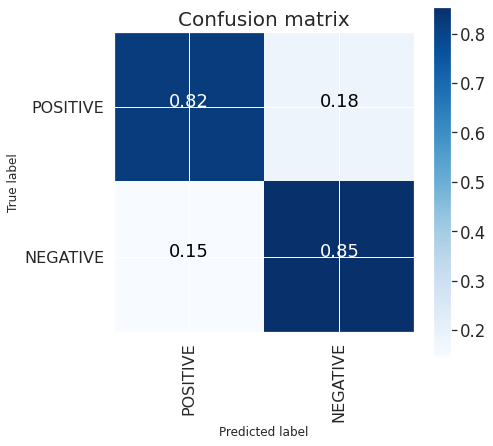

In [70]:
cnf_matrix = confusion_matrix(y_test, predicted_tweets_binary)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=train.target.unique(), title="Confusion matrix")
plt.show()

# Comprehensive Report

In [71]:
print('Precision: %.4f' % precision_score(y_test, predicted_tweets_binary))
print('Recall: %.4f' % recall_score(y_test, predicted_tweets_binary))
print('Accuracy: %.4f' % accuracy_score(y_test, predicted_tweets_binary))
print('F1 Score: %.4f' % f1_score(y_test, predicted_tweets_binary))
print(classification_report(y_test, predicted_tweets_binary))

Precision: 0.8268
Recall: 0.8546
Accuracy: 0.8374
F1 Score: 0.8405
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      7982
           1       0.83      0.85      0.84      8018

    accuracy                           0.84     16000
   macro avg       0.84      0.84      0.84     16000
weighted avg       0.84      0.84      0.84     16000



# Error Analysis

When you start looking at the inside of the data with predicted labels, you will realise that there are lots of mislabeled texts beforehand. Therefore, it is expected to not get really high accuracy. However, we can say that our model works pretty good against its competitors.

In [72]:
decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [77]:
df = pd.DataFrame(test.text, columns=["text"])
df['ids'] = test.ids
df["actual"] = test.target
df["predicted"] = predicted_tweets_binary
df.predicted = df.predicted.apply(lambda x: decode_sentiment(x))
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
incorrect = df[df["actual"] != df["predicted"]]
incorrect[10:20]

,text,ids,actual,predicted
1328830,"@disil429 Fine. Kinders coughing again, so not a lot of sleep. Weather's good, though, that's the main thing",2015570824,POSITIVE,NEGATIVE
926384,"i miss him, i cant wait to see him, im happy",1755641038,POSITIVE,NEGATIVE
1501551,"@mithss mourniiiiiiing eh, morniiing!!!",2071479153,POSITIVE,NEGATIVE
222,"@PaulaAbdul awww, Good luck Paula!! Please don't work too hard but I hope you have fun Your new album is gonna be amazing! xxx",1467871545,NEGATIVE,POSITIVE
1121819,Home from soccer. It's so hot out there today. We have retreated to the coolness of the basement.,1974221419,POSITIVE,NEGATIVE
1278593,it is ginormous... Haha well i feel wierd talking about myy ziiiit ta ta good nightt,2001445043,POSITIVE,NEGATIVE
904643,One interlock down one to go,1694881980,POSITIVE,NEGATIVE
374134,@dbferguson I'm using an Asus. Forget which one at the moment since I don't have it near me.But my complaints are similar to yours.,2051178100,NEGATIVE,POSITIVE
120956,@softjunebreeze Ex-factor.... Me too,1833398181,NEGATIVE,POSITIVE
25844,Back to school on Monday...Well I did get an iPod Touch. @shmuxel + @randomized180 See yah tomorrow then I guess,1558501113,NEGATIVE,POSITIVE


In [78]:
correct = df[df['actual'] == df['predicted']]
correct.head(10)

,text,ids,actual,predicted
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,2200003196,NEGATIVE,NEGATIVE
750,"@misstoriblack cool , i have no tweet apps for my razr 2",1467998485,NEGATIVE,NEGATIVE
285055,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,1993474027,NEGATIVE,NEGATIVE
705995,upper airways problem,2256550904,NEGATIVE,NEGATIVE
379611,Going to miss Pastor's sermon on Faith...,2052380495,NEGATIVE,NEGATIVE
1189018,on lunch....dj should come eat with me,1983449090,POSITIVE,POSITIVE
667030,@piginthepoke oh why are you feeling like that?,2245479748,NEGATIVE,NEGATIVE
93541,gahh noo!peyton needs to live!this is horrible,1770705699,NEGATIVE,NEGATIVE
1097326,@mrstessyman thank you glad you like it! There is a product review bit on the site Enjoy knitting it!,1970386589,POSITIVE,POSITIVE
1380171,@PerezHilton Zach makes me pee sitting down! And I'm a grown gay man!,2052206835,POSITIVE,POSITIVE


____
### Twint's key is not avaliable after 05.01.2022, sadly. But, was perfect tool to scrape tweets. Last try at 18.01.2022.

**Error name is:** *twint.token.RefreshTokenException: Could not find the Guest token in HTML* <br/>
**A github issue for this:** [twint error](https://github.com/twintproject/twint/issues/1114) <br/>
After they fix the issue, feel free to use this tool. The implementation is below.
____

# Fetching data from Twitter
To get started,

* Import the twint package as follows.

In [ ]:
!pip install twint
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
import twint
import nest_asyncio

In [ ]:
c = twint.Config()

c.Search = "elonmusk" #keyword for search
c.Limit = 20 #limit of the number of tweets which will be extracted
c.Store_csv = True 
c.Output = 'elonmusk_tweet_data.csv'

nest_asyncio.apply()
twint.run.Search(c)

## We stored the related tweets in the .csv or .json file which is really fast and cool

So how we will read from csv/json file to use for our purpose ? 

In [ ]:
crawled_data = pd.read_csv("elonmusk_tweet_data.csv")
#crawled_data = pd.read_json("tweet_data.json", lines=True)
pd.options.display.max_columns=36
crawled_data.head()

_____
As you can see above we have lots of features which extracted by twint. However, we only need the "tweet" feature which includes the text data of tweets for our purpose.

In [ ]:
# prediction of the first 15 extracted tweets
for i in range(15):
    print(crawled_data["tweet"][i])
    print(predict(crawled_data["tweet"][i]))
    print("\n")

### If you want to know more about twint, you can checkout this Github link:
https://github.com/twintproject/twint